In [1]:
import json
from notebooks.util import make_best_flow_kwargs_col
import pandas as pd

with open("../results.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['general_experiment'])
df['flow_kwargs'] = df['flow_kwargs'].map(str)
df['best_kwargs'] = make_best_flow_kwargs_col(df)
df.loc[df['flow'] == 'radial', 'best_kwargs'] = True  # fix

In [2]:
# Jumps
# For each flow, look at IMH. For how many targets does it beat MH? And HMC?

hmc_b2 = df[df['sampler'] == 'hmc'][['benchmark', 'second_moment_squared_bias']].set_index('benchmark')
mh_b2 = df[df['sampler'] == 'mh'][['benchmark', 'second_moment_squared_bias']].set_index('benchmark')

imh_b2_min = pd.DataFrame(df[(df['flow'] != 'None') & (df['sampler'] == 'imh')].groupby(['flow', 'benchmark'])['second_moment_squared_bias'].min())
neutra_hmc_b2_min = pd.DataFrame(df[(df['flow'] != 'None') & (df['sampler'] == 'neutra_hmc')].groupby(['flow', 'benchmark'])['second_moment_squared_bias'].min())
neutra_mh_b2_min = pd.DataFrame(df[(df['flow'] != 'None') & (df['sampler'] == 'neutra_mh')].groupby(['flow', 'benchmark'])['second_moment_squared_bias'].min())

imh_b2_median = pd.DataFrame(df[(df['best_kwargs']) & (df['flow'] != 'None') & (df['sampler'] == 'imh')].groupby(['flow', 'benchmark'])['second_moment_squared_bias'].median())
neutra_hmc_b2_median = pd.DataFrame(df[(df['best_kwargs']) & (df['flow'] != 'None') & (df['sampler'] == 'neutra_hmc')].groupby(['flow', 'benchmark'])['second_moment_squared_bias'].median())
neutra_mh_b2_median = pd.DataFrame(df[(df['best_kwargs']) & (df['flow'] != 'None') & (df['sampler'] == 'neutra_mh')].groupby(['flow', 'benchmark'])['second_moment_squared_bias'].median())

In [3]:
def get_efficiency(d1, d2):
    # d1 is the NFMC method df, d2 is the MCMC method df
    tmp = d1.reset_index().merge(d2.reset_index(), on='benchmark', how='inner')
    tmp['improvement'] = tmp['second_moment_squared_bias_x'] < tmp['second_moment_squared_bias_y']
    return tmp.groupby('flow')['improvement'].mean()

In [4]:
from util import get_standard_flow_order

jump_efficiency_best = pd.concat(
    [
        pd.DataFrame(get_efficiency(imh_b2_min, mh_b2)),
        pd.DataFrame(get_efficiency(imh_b2_min, hmc_b2)),
    ],
    axis=1
)
jump_efficiency_best.columns = ['gf', 'gb']
jump_efficiency_best = jump_efficiency_best.iloc[get_standard_flow_order(jump_efficiency_best.index)]


jump_efficiency_median = pd.concat(
    [
        pd.DataFrame(get_efficiency(imh_b2_median, mh_b2)),
        pd.DataFrame(get_efficiency(imh_b2_median, hmc_b2)),
    ],
    axis=1
)
jump_efficiency_median.columns = ['gf', 'gb']
jump_efficiency_median = jump_efficiency_median.iloc[get_standard_flow_order(jump_efficiency_median.index)]

In [5]:
prec_efficiency_best = pd.concat(
    [
        pd.DataFrame(get_efficiency(neutra_mh_b2_min, mh_b2)),
        pd.DataFrame(get_efficiency(neutra_hmc_b2_min, hmc_b2)),
    ],
    axis=1
)
prec_efficiency_best.columns = ['gf', 'gb']
prec_efficiency_best = prec_efficiency_best.iloc[get_standard_flow_order(prec_efficiency_best.index)]

prec_efficiency_median = pd.concat(
    [
        pd.DataFrame(get_efficiency(neutra_mh_b2_median, mh_b2)),
        pd.DataFrame(get_efficiency(neutra_hmc_b2_median, hmc_b2)),
    ],
    axis=1
)
prec_efficiency_median.columns = ['gf', 'gb']
prec_efficiency_median = prec_efficiency_median.iloc[get_standard_flow_order(prec_efficiency_median.index)]

In [6]:
# Preconditioning
# For each flow, look at NeuTra. For how many targets does its NeuTra MH beat MH? And NeuTra HMC vs HMC?

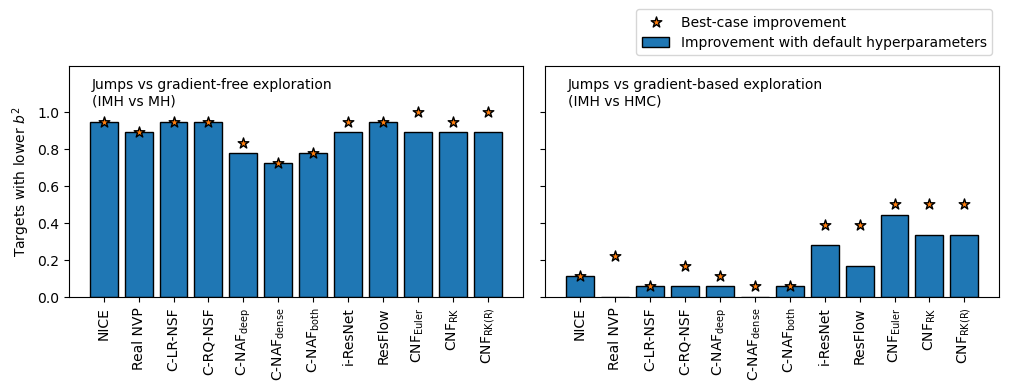

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from util import FLOW_PRETTY_MATH

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

jump_flows = [FLOW_PRETTY_MATH[f] for f in jump_efficiency_best.index]

axes[0].bar(np.arange(len(jump_flows)), jump_efficiency_median['gf'], ec="k",)
axes[1].bar(np.arange(len(jump_flows)), jump_efficiency_median['gb'], ec="k", label='Improvement with default hyperparameters')
axes[0].scatter(np.arange(len(jump_flows)), jump_efficiency_best['gf'], ec="k", marker='*', s=2**6)
axes[1].scatter(np.arange(len(jump_flows)), jump_efficiency_best['gb'], ec="k", marker='*', s=2**6, label='Best-case improvement')

axes[0].set_ylabel('Targets with lower $b^2$')

axes[0].set_xticks([])

axes[0].set_ylim(0, 1.25)
axes[1].set_ylim(0, 1.25)

axes[1].legend(bbox_to_anchor=(1.0, 1.275), loc='upper right')

axes[0].set_xticks(np.arange(len(jump_flows)), jump_flows, rotation=90)
axes[1].set_xticks(np.arange(len(jump_flows)), jump_flows, rotation=90)

axes[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

axes[0].text(0.05, 0.95, 'Jumps vs gradient-free exploration\n(IMH vs MH)', transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(0.05, 0.95, 'Jumps vs gradient-based exploration\n(IMH vs HMC)', transform=axes[1].transAxes, ha='left', va='top')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig('images/jump-efficiency.pdf', bbox_inches='tight')
fig.savefig('images/jump-efficiency.png', bbox_inches='tight', dpi=600)
plt.show()

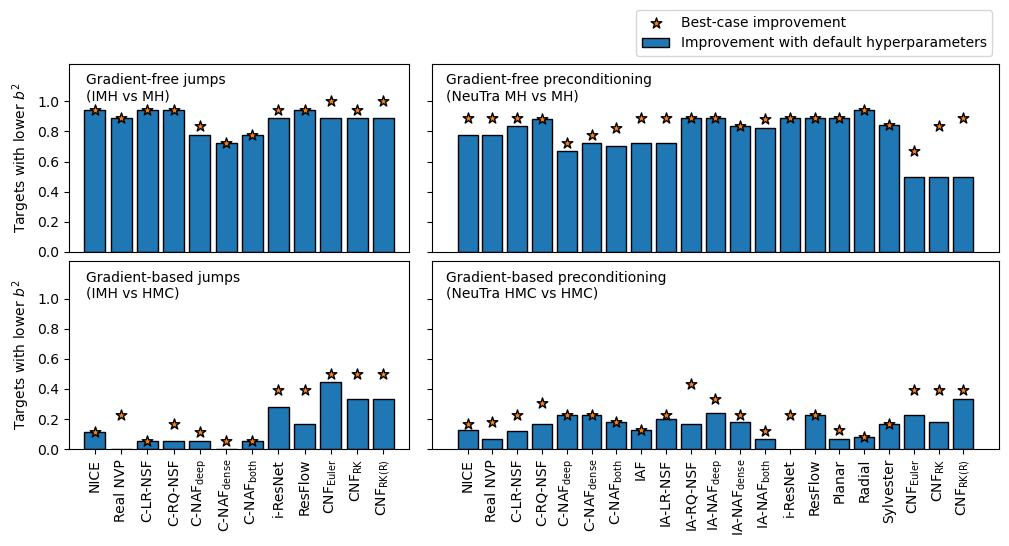

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from util import FLOW_PRETTY_MATH

fig, axes = plt.subplots(2, 2, width_ratios=[3, 5], figsize=(12, 5), sharey=True)

jump_flows = [FLOW_PRETTY_MATH[f] for f in jump_efficiency_best.index]
prec_flows = [FLOW_PRETTY_MATH[f] for f in prec_efficiency_best.index]

axes[0, 0].bar(np.arange(len(jump_flows)), jump_efficiency_median['gf'], ec="k",)
axes[1, 0].bar(np.arange(len(jump_flows)), jump_efficiency_median['gb'], ec="k",)
axes[0, 1].bar(np.arange(len(prec_flows)), prec_efficiency_median['gf'], ec="k",label='Improvement with default hyperparameters')
axes[1, 1].bar(np.arange(len(prec_flows)), prec_efficiency_median['gb'], ec="k",)

axes[0, 0].scatter(np.arange(len(jump_flows)), jump_efficiency_best['gf'], ec="k", marker='*', s=2**6)
axes[1, 0].scatter(np.arange(len(jump_flows)), jump_efficiency_best['gb'], ec="k", marker='*', s=2**6)
axes[0, 1].scatter(np.arange(len(prec_flows)), prec_efficiency_best['gf'], ec="k", marker='*', s=2**6, label='Best-case improvement')
axes[1, 1].scatter(np.arange(len(prec_flows)), prec_efficiency_best['gb'], ec="k", marker='*', s=2**6)

axes[0, 0].set_ylabel('Targets with lower $b^2$')
axes[1, 0].set_ylabel('Targets with lower $b^2$')

axes[0, 0].set_xticks([])
axes[0, 1].set_xticks([])

axes[0, 0].set_ylim(0, 1.25)
axes[0, 1].set_ylim(0, 1.25)
axes[1, 0].set_ylim(0, 1.25)
axes[1, 1].set_ylim(0, 1.25)

axes[1, 0].set_xticks(np.arange(len(jump_flows)), jump_flows, rotation=90)
axes[1, 1].set_xticks(np.arange(len(prec_flows)), prec_flows, rotation=90)
axes[0,0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

axes[0, 0].text(0.05, 0.95, 'Gradient-free jumps\n(IMH vs MH)', transform=axes[0, 0].transAxes, ha='left', va='top')
axes[1, 0].text(0.05, 0.95, 'Gradient-based jumps\n(IMH vs HMC)', transform=axes[1, 0].transAxes, ha='left', va='top')
axes[0, 1].text(0.025, 0.95, 'Gradient-free preconditioning\n(NeuTra MH vs MH)', transform=axes[0, 1].transAxes, ha='left', va='top')
axes[1, 1].text(0.025, 0.95, 'Gradient-based preconditioning\n(NeuTra HMC vs HMC)', transform=axes[1, 1].transAxes, ha='left', va='top')

axes[0, 1].legend(bbox_to_anchor=(1.0, 1.325), loc='upper right')
fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig('images/jump-prec-efficiency.pdf', bbox_inches='tight')
fig.savefig('images/jump-prec-efficiency.png', bbox_inches='tight', dpi=600)
plt.show()

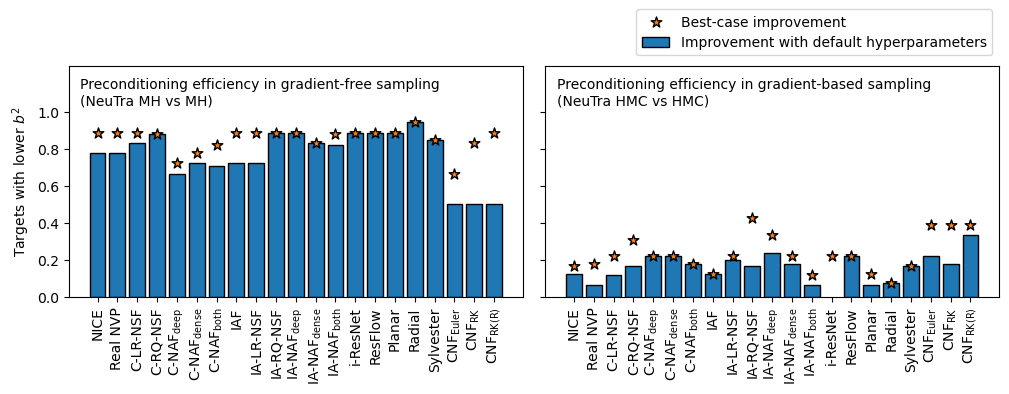

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from util import FLOW_PRETTY_MATH

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

prec_flows = [FLOW_PRETTY_MATH[f] for f in prec_efficiency_best.index]

axes[0].bar(np.arange(len(prec_flows)), prec_efficiency_median['gf'], ec="k",)
axes[1].bar(np.arange(len(prec_flows)), prec_efficiency_median['gb'], ec="k", label='Improvement with default hyperparameters')

axes[0].scatter(np.arange(len(prec_flows)), prec_efficiency_best['gf'], ec="k", marker='*', s=2**6)
axes[1].scatter(np.arange(len(prec_flows)), prec_efficiency_best['gb'], ec="k", marker='*', s=2**6, label='Best-case improvement')

axes[0].set_ylabel('Targets with lower $b^2$')
# axes[1].set_ylabel('Targets with lower $b^2$')

axes[0].set_xticks([])
axes[1].set_xticks([])

axes[0].set_ylim(0, 1.25)
axes[1].set_ylim(0, 1.25)

axes[1].legend(loc='upper right', bbox_to_anchor=(1.0, 1.275))

axes[0].set_xticks(np.arange(len(prec_flows)), prec_flows, rotation=90)
axes[1].set_xticks(np.arange(len(prec_flows)), prec_flows, rotation=90)
axes[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

axes[0].text(0.025, 0.95, 'Preconditioning efficiency in gradient-free sampling\n(NeuTra MH vs MH)', transform=axes[0].transAxes, ha='left', va='top')
axes[1].text(0.025, 0.95, 'Preconditioning efficiency in gradient-based sampling\n(NeuTra HMC vs HMC)', transform=axes[1].transAxes, ha='left', va='top')

fig.subplots_adjust(hspace=0.05, wspace=0.05)
fig.savefig('images/prec-efficiency.pdf', bbox_inches='tight')
fig.savefig('images/prec-efficiency.png', bbox_inches='tight', dpi=600)
plt.show()